<a href="https://colab.research.google.com/github/WNderitu/week4_project_advanced-ML/blob/main/AdvML_week4practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Week 4 Project: Global Wheat Detection**

**1.0 Introduction**

**1.1 Problem Statement**

Develop a deep learning model for wheat detection and disease classification to aid farmers in improving crop management and yield.  
The final goal is to create a reliable and efficient system that can assist farmers in making informed decisions regarding crop protection and overall agricultural practices.


**1.2 Deep learning Techniques Used**

A Convolutional Neural Network will be used for this image classification problem.
The tf.keras.Sequential model type will be used.
The model takes image inputs, processes them through several convolutional and pooling layers to extract visual features, and finally outputs predictions for 5 classes (since num_classes = 5).

**1.3 Model Architecture**

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them.
There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu').

**1.4 Training Methodology**

The model will be compiled using the Adam optimizer, the categorical cross-entropy loss function and accuracy as the evaluation metric.

The cross entropy loss function will measure the difference between two probability distributions: the true distribution of the target labels and the predicted distribution from the model.
The goal is to minimize this loss, making the model's predicted probabilities as close as possible to the actual probabilities.

**2.0. Installing & Importing Libraries**

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import PIL
import PIL.Image

In [4]:
# import skimage library for image processing
from skimage import data
from skimage.feature import  blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from math import sqrt
from skimage.io import imread


In [6]:
# import tensor flow modules
from tensorflow import keras

# import keras api
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

**3.0 Importing & preprocessing the images**

In [7]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the image folder in Google Drive
image_folder_path = '/content/drive/MyDrive/global-wheat-detection' # Assuming the folder is in the root of your Drive

# Check if the folder exists
if not os.path.exists(image_folder_path):
    print(f"Error: Folder not found at {image_folder_path}")
else:
    # Create a TensorFlow dataset from the image folder
    # This assumes your images are organized in subdirectories by class
    # If not, you might need to adjust the image_dataset_from_directory parameters
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        image_folder_path,
        labels='inferred', # Assumes subdirectory names are class labels
        label_mode='int', # Or 'categorical' depending on your model output
        image_size=(256, 256), # Specify the desired image size
        interpolation='nearest', # Choose an interpolation method
        batch_size=32, # Specify the batch size
        shuffle=True # Shuffle the data
    )

    # Print the class names
    class_names = image_dataset.class_names
    print("Class names:", class_names)


Mounted at /content/drive
Found 3432 files belonging to 2 classes.
Class names: ['test', 'train']


In [8]:
# get image count
from glob import glob
image_count = len(glob('/content/drive/MyDrive/global-wheat-detection/*/*.jpg'))
print(image_count)

3432


In [9]:
# load dataset using keras utility
batch_size = 32
img_height = 180
img_width = 180

In [10]:
# Determine the number of images in the dataset
image_count = tf.data.experimental.cardinality(image_dataset).numpy()
train_size = int(0.8 * image_count)
val_size = int(0.2 * image_count)

# Split the dataset into training and validation sets
train_ds = image_dataset.take(train_size)
val_ds = image_dataset.skip(train_size).take(val_size)

print("Number of training images:", tf.data.experimental.cardinality(train_ds).numpy())
print("Number of validation images:", tf.data.experimental.cardinality(val_ds).numpy())

Number of training images: 86
Number of validation images: 21


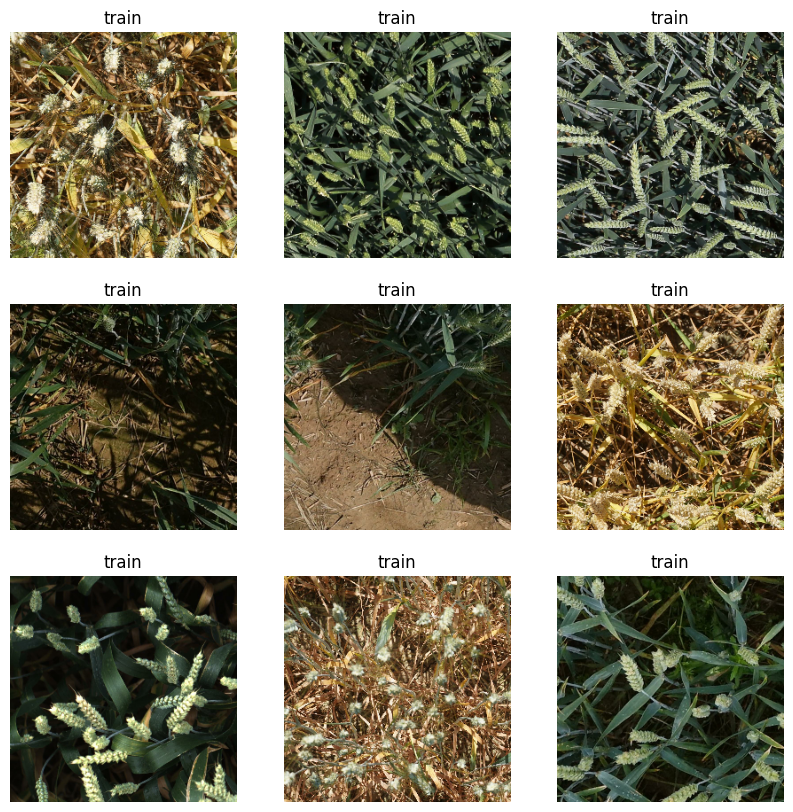

In [11]:
# visualise the data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE  # lets TensorFlow automatically decide the optimal number of parallel calls and buffer sizes for data loading. This means TensorFlow will tune performance dynamically based on system’s resources.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# Standardize the data
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97647065


**4.0 Model Training**

In [15]:
# using a sequential model, train the model
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [16]:
# add early stopping or model checkpointing (to prevent overfitting and save the best model automatically)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # what to monitor (can also use 'val_accuracy')
    patience=3,                # number of epochs to wait for improvement
    restore_best_weights=True  # revert to best model after stopping
)

In [17]:
# view training and validation accuracy
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [19]:
# add early stopping or model checkpointing (to prevent overfitting and save the best model automatically)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',        # what to monitor (can also use 'val_accuracy')
    patience=3,                # number of epochs to wait for improvement
    restore_best_weights=True  # revert to best model after stopping
)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',   # file to save the model
    monitor='val_accuracy',        # what to track for “best” model
    save_best_only=True,           # only save when performance improves
    mode='max'                     # maximize accuracy
)

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.9563 - loss: 0.2359 - val_accuracy: 0.9970 - val_loss: 0.0313
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.9976 - loss: 0.0427 - val_accuracy: 0.9970 - val_loss: 0.0178
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.9972 - loss: 0.0402 - val_accuracy: 0.9970 - val_loss: 0.0178
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.9971 - loss: 0.0205 - val_accuracy: 0.9970 - val_loss: 0.0241
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9968 - loss: 0.0188 - val_accuracy: 0.9970 - val_loss: 0.0209
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9967 - loss: 0.0116 - val_accuracy: 0.9970 - val_loss: 0.0166
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.9969 - loss: 0.0066 - val_accuracy: 0.9970 - val_loss: 0.0353
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.9983 - loss: 0.0095 - val_accuracy: 0.9970 - v

In [22]:
# Load the best saved model later
best_model = tf.keras.models.load_model('best_model.keras')

loss, acc = best_model.evaluate(val_ds)
print(f"Restored best model accuracy: {acc:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 901ms/step - accuracy: 0.9935 - loss: 0.0732
Restored best model accuracy: 0.9970
